# **Number detection algorithm**

## **Image Traitement**

Before using the ML algorithm it must verify that the images that will be used in the classification is in the same format and size as the ones in the database (MNIST)

In [2]:
import os
import csv
import cv2 as cv
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

from keras.datasets import mnist
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import itertools
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [3]:
# This function is responsable to open all the images obtained by the camera and already processed. 
# The images are transform to be able to compare with the EMNIST database. To do so, basically,
# the function bellow identiify the number in the image, remove this number, insert it in a new image
# in the format of the database and create a file test.cvs to be use by the machine learning's algorithms. 

def image_traitement(image_path):

    # set the parameters to read the images
    image_path_chiffre = image_path # path of the file
    chiffre = image_path_chiffre[-2] # number of the dice

    # list to store all the images in the folder
    image_list = []
    for x in os.listdir(image_path_chiffre):
        path_image = image_path_chiffre + x
        im = cv.imread(path_image, 0)
        image_list.append(im)

    # list with images after the processing
    resized_list = []

    # image processing for each image of the folder
    for im in image_list:

        # convert the color to gray
        imgray = cv.cvtColor(im, cv.COLOR_GRAY2BGR) #for better accuracy, use binary images
        
        # apply the threshold to invert the pixels of the image
        # all pixels value equal to 255 (white) will be set to 0 (black)
        ret, thresh = cv.threshold(im, 225, 255, cv.THRESH_BINARY_INV) #OBS: try change to imgray
        #plt.imshow(im, cmap='gray') # image with the pixels inverted
        
        # calculate all the countors of the image
        # the variable contours contains points of the countors
        contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        
        # loop over the contours points, calculate the area of these points and 
        # chose the first area that is sufficently large
        for i in range(len(contours)):

            # calcul de la zone des contours
            area = cv.contourArea(contours[i])

            # if the contour is sufficiently large, it must be the digit
            if area > 50 and area < 700:
                
                # compute the bounding box where (x,y) is the top-left coordinate of the rectangle 
                # and (w,h) is the width and height
                (x, y, w, h) = cv.boundingRect(contours[i]) # calcul de coordonnes de la zone

                # affiche les rectangles sur l'image binaire
                #cv.rectangle(imgray, (x,y), (x+w,y+h), (255,255,0), 2) 

                # extract the region of interest (ROI) using the informations of the bounding box
                diceROI = thresh[y-2 : y+h+2, x-2 : x+w+2] # extraction de la zone sur l'image    
                #plt.matshow(diceROI, cmap="gray")
                break
                 
        # calculate the center of mass, the height and the width of the ROI
        centre_h, centre_w = ndimage.measurements.center_of_mass(diceROI)
        h, w = diceROI.shape
        
        # create a new image and insert the ROI
        n = 56 # the ROI will be insert in the center of a bigger image
        
        black_image = np.zeros((n,n))
        black_image[int((n-h)/2) : int(((n-h)/2)+h), int((n-w)/2) : int(((n-w)/2)+w)] = diceROI 
        #plt.matshow(black_image, cmap='gray')

        # resize the image to the format 28x28 pixel (format of the database)
        scale_percent = 50 # percent of original size
        
        width = int(black_image.shape[1] * scale_percent / 100)
        height = int(black_image.shape[0] * scale_percent / 100)
        dim = (width, height)

        # resize the image
        resized = cv.resize(black_image, dim, interpolation = cv.INTER_AREA)
        resized_list.append(resized) # add to the list of final images

        # write the pixel matrix in the test.csv file, the row will have 785 columns (28x28 + 1)
        # where the last column is the dice's number
        A = np.asarray(resized).reshape(-1) # shape the matrix to just one line
        
        row = []
        for result in A:
            row.append(result)
        row.append(float(chiffre)) #the last column is the dice's number

        # open the file in the for appending new information (new row)
        with open('test.csv', "a") as file:
            writer = csv.writer(file)
            writer.writerow(row) 

    # print the processed images 
    #print("Dice's number: " + str(chiffre))
    #print("Number of the images in the folder: " + str(len(image_list)))
    #print("Number of the images created: " + str(len(resized_list)))
    #for pos in range(0, len(resized_list)):
    #    plt.matshow(resized_list[pos], cmap='gray')
    '''
    if os.path.isfile('test.csv'):
        print ("END")
    else:
        print ('file does not exist')
    '''

# Read database

Functions used to read the database (train and test) from MNIST and also from the csv file generated with the images captured from the pico camera

In [4]:
#Extract the numbers from database

def selectDiceNumbers(img_list_all, labels_list_all):
    img_final = []
    labels_final = []
    diceNumbers = [1, 2, 3, 4, 5, 6]

    if len(img_list_all) == len(labels_list_all):
        initialSize = range(len(img_list_all))
    else:
        print("Size of lists must be the same!")

    for i in initialSize:
        if (labels_list_all[i] in diceNumbers):
            img_final.append(img_list_all[i])
            labels_final.append(labels_list_all[i])
    
    return img_final, labels_final

def load_datasets():
    print("Loading Training dataset and Testing dataset...")
    (img_train_all, labels_train_all),(img_test_all, labels_test_all) = mnist.load_data()
    
    img_train, labels_train = selectDiceNumbers(img_train_all, labels_train_all)
    img_test, labels_test = selectDiceNumbers(img_test_all, labels_test_all)

    print("Finished loading!")
    
    return img_train, labels_train, img_test, labels_test
    
X_train, Y_train, X_test, Y_test = load_datasets()
#Train dataset size = 36012
#Test dataset size = 6009

Loading Training dataset and Testing dataset...
Finished loading!


In [5]:
def create_number_list(data):
    images = []
    for x in data:
        images.append(x.reshape(-1))

    return images

In [6]:
def read_test():    
    image = []
    labels = []
    with open('test.csv', 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter = ',', quotechar = '|', quoting = csv.QUOTE_NONNUMERIC)
        for line in spamreader:
            image.append(np.array(line[:-1]))
            labels.append(line[-1])
    
    return image, labels

# **Evaluation methods**

This part contains the functions used to analyse the accuracy of the classifier

In [7]:
def plot_confusion_matrix(clf, data_x, data_y):
    classes = ['1', '2', '3', '4', '5', '6']

    Ypred = clf.predict(data_x)
    
    # Computation of confusion matrix on testing set
    cm = confusion_matrix(data_y, Ypred)
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [8]:
def tuning_parameter(start_value, end_value, N):
    # Model training and accuracy computation for different parameters
    values = [i for i in range(start_value, end_value)]
    accs_train = []
    accs_test  = []
    accs_test_photos = []

    # Train on the first N train images
    train_x = create_number_list(X_train[:N])
    train_y = np.array(Y_train[:N])

    # Test on the next N/6 test images:
    test_x = create_number_list(X_test[:N/6])
    test_y = np.array(Y_test[:N/6]) 
    
    test_x_photos, test_y_photos = read_test()
    
    for i in values:
        clf = DecisionTreeClassifier(random_state = 0, max_depth = i)
        clf.fit(train_x, train_y)
        accs_train.append(clf.score(train_x, train_y))
        accs_test.append(clf.score(test_x, test_y))
        accs_test_photos.append(clf.score(test_x_photos, test_y_photos))
       
    plt.figure(figsize=(16, 8))

    # Draw accuracies as a function of the depth for both trainin and testing sets
    plt.title("Decision Tree")   
    plt.plot(values, accs_train, label = 'Train Accuracy')
    plt.plot(values, accs_test,  label = 'Test Accuracy')
    plt.plot(values, accs_test_photos,  label = 'Test photos Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Parameter')
    plt.legend()
    plt.xticks(values)
    plt.show()
    
    return accs_train, accs_test, accs_test_photos

# **Decision Tree Model algorithm**

In [9]:
def train_decisionTreeModel(N, i):
    # Train on the first N train images
    train_x = create_number_list(X_train[:N])
    train_y = np.array(Y_train[:N])
    
    #Train the classifier
    clf = DecisionTreeClassifier(random_state = 0, max_depth = i)
    print("Finished trainning Decision Tree Model with " + str(i) + " maximum depth")
    return clf.fit(train_x, train_y)

decisionTree_classificator = train_decisionTreeModel(1000, 5)

Finished trainning Decision Tree Model with 5 maximum depth


The accuracy for the MNIST Database is: 65.663%
Using: 1000 images


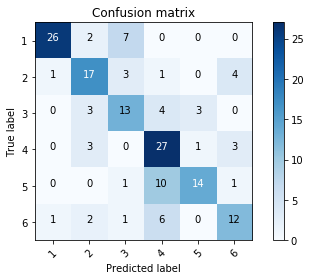

In [10]:
def test_decisionTreeModel(N):
    # Test on the next N/6 test images:
    test_x = create_number_list(X_test[:N/6])
    test_y = np.array(Y_test[:N/6]) 
    predicted = decisionTree_classificator.predict(test_x)
    print("The accuracy for the MNIST Database is: " + str(round((accuracy_score(test_y, predicted) * 100), 3)) + "%")

    print("Using: " + str(N) + " images")
    
    plt.title("Confusion Matrix for test database")
    plot_confusion_matrix(decisionTree_classificator, test_x, test_y)
    plt.show()

test_decisionTreeModel(1000)

The accuracy for the photos taken is: 15.789%
Using: 38 images


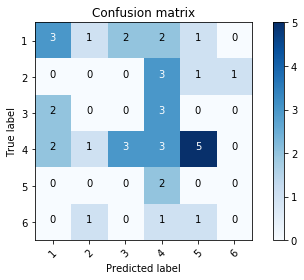

In [11]:
def test_photos_decisionTreeModel():
    #New set of values
    test_x_photos, test_y_photos = read_test()
    predicted_photos = decisionTree_classificator.predict(test_x_photos)

    print("The accuracy for the photos taken is: " + str(round((accuracy_score(test_y_photos, predicted_photos) * 100), 3)) + "%")
    print("Using: " + str(len(test_y_photos)) + " images")

    plt.title("Confusion Matrix Photos taken")
    plot_confusion_matrix(decisionTree_classificator, test_x_photos, test_y_photos)
    plt.show()
    
test_photos_decisionTreeModel()

# Improving the classificator

This part consist in making a study of the hyperparameter of the classifcator to improve the classification

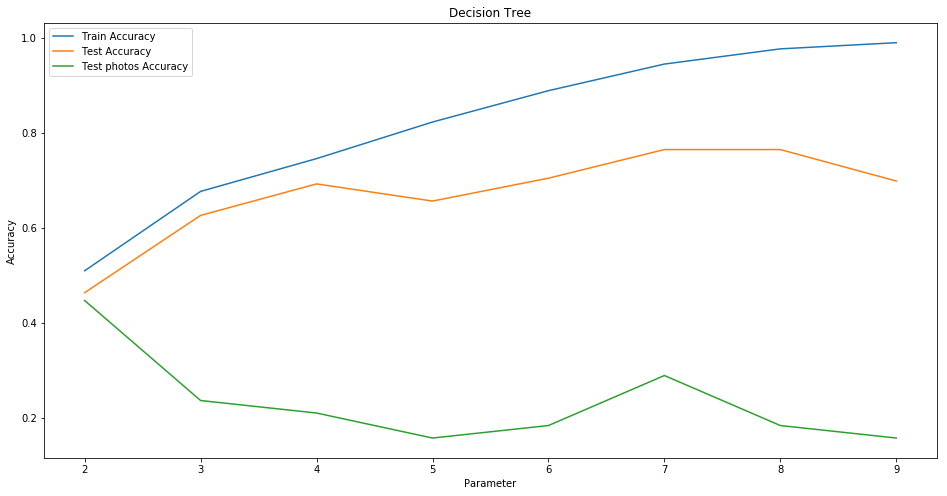

In [12]:
# Start value:
# End value: 
# N: Number of number that will be trained
# Fist argument is the model (1 to 4 possible models)
# 1 ==> Decision Tree Classifier
# 2 ==> KK neighbors Classifier
# 3 ==> Random Forest Classifier
# 4 ==> SVM Classifier
acc_train, acc_test, acc_test_photos = tuning_parameter(2, 10, 1000)

In [13]:
print("TRAINNING RESULTS")
print("Maximum accuracy is: " + str(round((np.max(acc_train) * 100), 3)) + "%")
print("When the hyperparameter is: " + str(np.argmax(acc_train) + 1))
print('\n')
print("TEST RESULTS - Using the database from MNIST")
print("Maximum accuracy is: " + str(round((np.max(acc_test) * 100), 3)) + "%")
print("When then the hyperparameter is: " + str(np.argmax(acc_test) + 1))
print('\n')
print("TEST RESULTS - Using the photos taken")
print("Maximum accuracy is: " + str(round((np.max(acc_test_photos) * 100), 3)) + "%")
print("When then the hyperparameter is: " + str(np.argmax(acc_test_photos) + 1))


TRAINNING RESULTS
Maximum accuracy is: 99.0%
When the hyperparameter is: 8


TEST RESULTS - Using the database from MNIST
Maximum accuracy is: 76.506%
When then the hyperparameter is: 6


TEST RESULTS - Using the photos taken
Maximum accuracy is: 44.737%
When then the hyperparameter is: 1


# Best classificator

In [14]:
decisionTree_classificator = train_decisionTreeModel(1000, 6)

Finished trainning Decision Tree Model with 6 maximum depth


The accuracy for the MNIST Database is: 70.482%
Using: 1000 images


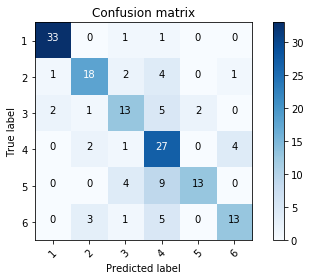

In [15]:
test_decisionTreeModel(1000)

The accuracy for the photos taken is: 18.421%
Using: 38 images


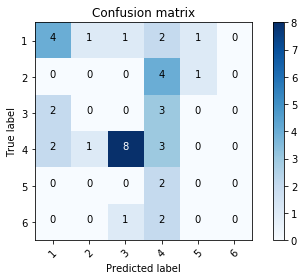

In [19]:
test_photos_decisionTreeModel()

# RASCUNHO

In [10]:
def DecisionTree():
    print("Decision Tree model")
    clf = DecisionTreeClassifier(random_state = 0, max_depth = 5)

    test(clf, 10000)
    
def KK():
    print("KK neighbors model")
    clf = KNeighborsClassifier(n_neighbors = 1)

    test(clf, 10000)

def RandomForest():
    print("Random Forest model")
    clf = RandomForestClassifier(n_estimators=100)

    test(clf, 10000)
    
def SVM():
    print("SVM model")
    clf = svm.LinearSVC(random_state=0)

    test(clf, 10000)